<div style="border: 2px solid red; padding: 10px; border-radius: 5px;">
<strong>Notebook description:</strong>
    
Plotting mitohealth results 

<strong>Input Data:</strong>

`neuronbatch11082023_mitohealth_out_quant_continuous.csv` 

`neuronbatch11222023_mitohealth_out_quant_continuous.csv`

`neuronbatch11152023_mitohealth_out_quant_continuous.csv` 

<strong>Figures:</strong>

`fig3`

<strong>Last Run All:</strong>
June 18, 2025


In [2]:
import sys
sys.path.append('/Users/djuna/Documents/ABCA7lof2/')

from ABCA7lof2.utils import apply_custom_plot_style
apply_custom_plot_style()

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import numpy as np
import numpy as np
import pandas as pd
import statsmodels.api as sm
import numba as nb
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.formula.api import mixedlm
from tqdm import tqdm 
from aicsimageio import AICSImage

import statsmodels.api as sm
import statsmodels.formula.api as smf
def load_image(path):
    img = AICSImage(path)
    reshaped_img = img.data#.reshape(30, 1024, 1024)
    return int_to_float(reshaped_img)

def int_to_float(out):
    """
    Convert image data from integer to float format.

    Parameters:
    - out (np.ndarray): Input image data in integer format.

    Returns:
    - np.ndarray: Converted image data in float format.
    
    Note:
    If the input data type is 'uint16', the conversion is normalized to the range [0, 1]
    by dividing by ((2**16) - 1). If the input data type is 'uint8', the normalization
    is performed by dividing by ((2**8) - 1), resulting in the range [0, 1].
    """
    if out.dtype=='uint16':
        return out.astype(float)/((2**16)-1)
    elif out.dtype=='uint8':
        return out.astype(float)/((2**8)-1)
    


def fit_mixed_model(temp, mod, group):
    model = smf.mixedlm(mod, data=temp, groups=temp[group])
    result = model.fit()
    
    return result.summary()

def plot_boxplot_by_treatment(d, x_val, y_val, order, pairs, palette, ylim, ymin, pvalues=None):
    # Draw the boxplot with a semi-transparent fill (alpha=0.5) applied via boxprops.
    ax = sns.boxplot(
        data=d, 
        x=x_val, 
        y=y_val, 
        palette=palette, 
        order=order, 
        width=0.4, 
       # capsize=0.1, 
        linewidth=1,

        showfliers=False
    )

    ax.set_ylim(ymin,ylim)
    ax.set_xlim(-0.5, len(order)+5)
    # Overlay the stripplot
    sp = sns.stripplot(
        data=d, 
        x=x_val, 
        y=y_val, 
        dodge=False, 
        jitter=0.05, 
        alpha=1,  
        order=order, 
        color='black',
        #palette=palette,
        size=3
    )

    #plt.ylim(0, plt.ylim()[1])
    # Shift the stripplot points slightly to the left.
    shift = 0.4  # Adjust this value as needed
    for i, coll in enumerate(sp.collections):
        # if i == 0:
        #     shift = 0.4
        # elif i == 1:
        #     shift = 0.4
        # elif i == 2:
        #     shift = 0.4
            
        offsets = coll.get_offsets()
        # Subtract from the x-coordinate to move left
        offsets[:, 0] = offsets[:, 0] + shift
        coll.set_offsets(offsets)
    # Add statistical annotations
    annotator = Annotator(ax, pairs, data=d, x=x_val, y=y_val, order=order)
    #annotator.set_pvalues(pvalues)
    annotator.configure(text_format='full', loc='outside',line_offset_to_group=10,  # Increases space between the brackets and the plot
    text_offset=5)
    annotator.set_custom_annotations(pvalues)
    annotator.annotate()

    plt.xticks(rotation=0)
    plt.xlabel('')

    # Adjust the boxes so that the face remains semi-transparent while the edge is opaque.
    # Try iterating over both ax.artists and ax.patches.
    for patch in ax.patches:
        # Get the current facecolor (an RGBA tuple)
        fc = patch.get_facecolor()
        # Set the facecolor to have your desired alpha (e.g., 0.5)
        patch.set_facecolor((fc[0], fc[1], fc[2], 0.5))
        # Set the edgecolor to the same RGB but fully opaque (alpha=1)
        #patch.set_edgecolor((fc[0], fc[1], fc[2], 1.0))
        patch.set_linewidth(1)

    return ax
#plt.savefig('../../paper/main_plots/tmrm_choline_boxplot.png', dpi=300, bbox_inches='tight')


load data 

In [5]:
# scale and combine data
paths = ['../../mitohealth/neuronbatch11082023_mitohealth_out_quant_continuous.csv', # this batch has only 2 DGAT replicates
        '../../mitohealth/neuronbatch11222023_mitohealth_out_quant_continuous.csv',
        '../../mitohealth/neuronbatch11152023_mitohealth_out_quant_continuous.csv']

o = []
x=0
for i in paths:
    out_parent = i
    df = pd.read_csv(out_parent)
    
    df_sele = df[((df['treatment']=='vehicle') | (df['treatment']=='CDP-choline')) & (df['line']=='Y622')]

    # Find the minimum number of rows per 'line'
    min_rows_per_line = df_sele.groupby('line').size().min()

    # Sample uniformly without replacement
    sampled_df = df_sele.groupby('line').apply(lambda x: x.sample(n=min_rows_per_line, random_state=1)).reset_index(drop=True)

    sampled_df['scaled']  = (sampled_df['mitohealth'] - np.mean(sampled_df['mitohealth']))/np.std(sampled_df['mitohealth'])
    
    sampled_df['batch'] = str(x)
    
    o.append(sampled_df)
    x+=1

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_1022/1902734255.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df_sele.groupby('line').apply(lambda x: x.sample(n=min_rows_per_line, random_state=1)).reset_index(drop=True)
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_1022/1902734255.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df_sele.groupby('l

In [7]:
# concat data

data = pd.concat(o)#[:2])
data['well'] = [i.split('-')[0] for i in data['file']]
data['well'] = data['batch'].str.cat(data['well'], sep=' ')

data.index = range(data.shape[0])

# get average scaled data
mean_scaled = data.groupby(['well', 'treatment'])['scaled'].mean().reset_index()


compute stats

In [9]:
# compute stats
outY = fit_mixed_model(data[data['line']=='Y622'], "scaled ~ treatment", 'well')
y622_pval = float(outY.tables[1][['P>|z|']].loc['treatment[T.vehicle]'].values[0])
pvalues = [y622_pval]

In [10]:
# load image for physical pixel size
import matplotlib.patches as patches

img = AICSImage('../../mitohealth/E04-1.czi')

img.physical_pixel_sizes

PhysicalPixelSizes(Z=1.0, Y=0.62392578125, X=0.62392578125)

plot

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_59514/214454964.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


vehicle vs. CDP-choline: p=0.042


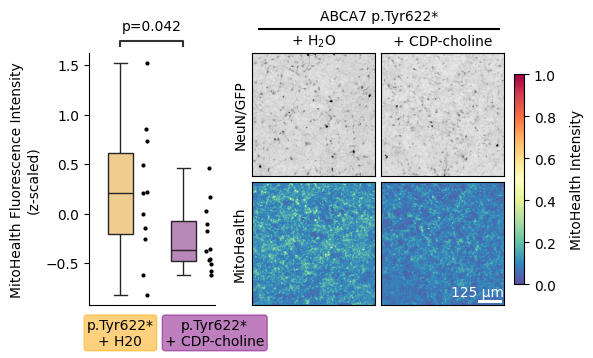

In [11]:
# Create a new figure with a gridspec with 1 row and 2 columns.
fig = plt.figure(figsize=(5, 3))
gs = fig.add_gridspec(1, 2, width_ratios=[0.6, 1.2])  # adjust ratios as needed

# ------------------
# Left: Boxplot panel
# ------------------
ax_box = fig.add_subplot(gs[0])
# (Option 1) If your function does not accept an ax parameter, you can set the current axes:
plt.sca(ax_box)

formatted_pvalues = [f"p={p:.3f}" if p>0.001 else f"p={p:.3e}" for p in pvalues]

ax_box = plot_boxplot_by_treatment(mean_scaled, 'treatment', 'scaled', order = ['vehicle', 'CDP-choline'], pairs = [('vehicle', 'CDP-choline')],palette={'vehicle': 'orange', 'CDP-choline': 'purple'}, 
                                ylim = np.max(mean_scaled['scaled']+.1), ymin = np.min(mean_scaled['scaled']-.1), pvalues=formatted_pvalues)

ax_box.set_ylabel('MitoHealth Fluorescence Intensity\n(z-scaled)', fontsize=10)
ax_box.set_xticks([])

# Optionally add your custom x-axis labels to ax_box
ax_box.text(0, -0.05, "p.Tyr622*\n+ H20", ha='center', va='top', 
            transform=ax_box.get_xaxis_transform(),
            bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), 
            fontsize=10)
ax_box.text(1.5, -0.05, "p.Tyr622*\n+ CDP-choline", ha='center', va='top', 
            transform=ax_box.get_xaxis_transform(),
            bbox=dict(boxstyle="round,pad=0.2", fc="purple", ec="purple", alpha=0.5), 
            fontsize=10)

ax_box.spines['top'].set_visible(False)
ax_box.spines['right'].set_visible(False)
#ax_box.set_ylim(0, 0.35)

# Create a nested gridspec for the right panel (2 rows x 2 columns)
gs_right = gs[1].subgridspec(2, 2, wspace=0.05, hspace=0.05)

# ------------------
# TOP ROW
# ------------------

# Top left image
ax_img1 = fig.add_subplot(gs_right[0, 0])

x = load_image('../../mitohealth/E02-1.czi')
f = np.max(x[0],axis=1)
f = np.transpose(f, (1, 2, 0)) 
val = 100
percentile_95 = np.percentile(f[:,:,1], val)
f[:,:,1]= np.clip(f[:,:,1], None, percentile_95) / percentile_95
gamma = 0.5
f_corrected = np.power(f[:,:,1], gamma)
ax_img1.imshow(f_corrected, vmin=0, vmax=1, cmap='gray_r')
ax_img1.set_title('+ H$_2$O', fontsize=10)
ax_img1.set_xticks([])
ax_img1.set_yticks([])
ax_img1.set_ylabel('NeuN/GFP')

ax_img2 = fig.add_subplot(gs_right[1, 0])
ax_img2.imshow(f[:,:,2], vmin=0, vmax=1, cmap='Spectral_r')
ax_img2.set_xticks([])
ax_img2.set_yticks([])
ax_img2.set_ylabel('MitoHealth')


# ------------------
# BOTTOM ROW
# ------------------

# Top left image
ax_img3 = fig.add_subplot(gs_right[0, 1])

x = load_image('../../mitohealth/E04-1.czi')
f = np.max(x[0],axis=1)
f = np.transpose(f, (1, 2, 0)) 
val = 100
percentile_95 = np.percentile(f[:,:,1], val)
f[:,:,1]= np.clip(f[:,:,1], None, percentile_95) / percentile_95
gamma = 0.5
f_corrected = np.power(f[:,:,1], gamma)
ax_img3.imshow(f_corrected, vmin=0, vmax=1, cmap='gray_r')
ax_img3.set_title('+ CDP-choline', fontsize=10)
ax_img3.set_xticks([])
ax_img3.set_yticks([])

ax_img4 = fig.add_subplot(gs_right[1, 1])
ax_img4.imshow(f[:,:,2], vmin=0, vmax=1, cmap='Spectral_r')
ax_img4.set_xticks([])
ax_img4.set_yticks([])


# Optionally add a colorbar to the right of the image panel
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('MitoHealth Intensity', labelpad=10)

# ------------------
# Final adjustments and save
# ------------------

# Add single bar and title spanning both columns
fig.text(0.65, 1.03, 'ABCA7 p.Tyr622*', horizontalalignment='center', fontsize=10)

# Add vertical bar above spanning both columns
bar_width = 5
bar_y = 1
fig.add_artist(plt.Line2D([0.41, 0.89], [bar_y, bar_y], color='black', transform=fig.transFigure))


##### SCALE BAR


# Assume the image dimensions in out_fppc[0] (height, width)
img_height, img_width = f[:,:,1].shape
bar_length = 200    # scale bar length in pixels (adjust as needed)
bar_height = 20     # thickness of the scale bar in pixels

# Position the scale bar in the lower right corner with some margin
margin = 20
x_start = img_width - bar_length - margin
y_start = img_height - margin

# Create a white rectangle for the scale bar
scale_bar = patches.Rectangle((x_start, y_start - bar_height), bar_length, bar_height, 
                               linewidth=0, edgecolor=None, facecolor='white')
ax_img4.add_patch(scale_bar)

# Add a text label above the scale bar (centered)
ax_img4.text(x_start, y_start-150, f'{bar_length * img.physical_pixel_sizes[1]:.0f} μm', 
                color='white', ha='center', va='top', fontsize=10)

plt.subplots_adjust(left=0.07, right=0.9, top=0.92, bottom=0.08)

plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/ed12/mitohealth_treatment.pdf', dpi=300, bbox_inches='tight')
